In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
from transformers import (BertTokenizer, BertModel,
                          DistilBertTokenizer, DistilBertModel, AutoModel, AutoConfig)
import codecs

In [3]:
from shopee_utils import *

In [4]:
PATH = Path('../input/shopee-product-matching')
model_file  = '../input/shopee-models/bert_large_state.pth'
if not PATH.is_dir():
    PATH = Path('/home/slex/data/shopee')
    model_file ='models/bert_large_state.pth'
model_config_path = './indobert-large-p2'

In [5]:
class CONF():
    tokens_max_length = 80
config=CONF()

In [6]:
TAKE_PAIRS = 5.1

In [7]:
train_df = pd.read_csv(PATH/'train.csv')
train_df = add_splits(train_df)

In [8]:
test_df = pd.read_csv(PATH/'test.csv')

In [9]:
class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_config_path)
        
        
    def encodes(self, row):
        text = row.title
        text=(codecs.decode(text, 'unicode_escape'))
        encodings = self.tokenizer(text, padding = 'max_length', max_length=config.tokens_max_length,
                                   truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask']#, 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

In [15]:
class EmbsModel(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
    def forward(self, x):
        output = self.bert_model(*x)
        return output.last_hidden_state[:,0,:]

In [10]:
tfm = TitleTransform()

data_block = DataBlock(
    blocks = (TransformBlock(type_tfms=tfm), 
              CategoryBlock(vocab=train_df.label_group.to_list())),
    splitter=ColSplitter(),
    get_y=ColReader('label_group'),
    )
dls = data_block.dataloaders(train_df, bs=128)


In [11]:
state_d = torch.load(model_file)

In [12]:
model = AutoModel.from_config(AutoConfig.from_pretrained(model_config_path))



In [13]:
model.load_state_dict(state_d,strict=True)

<All keys matched successfully>

In [16]:
model = EmbsModel(model).cuda().eval()

## Verify on validataion set

  0%|          | 0/54 [00:00<?, ?it/s]

0.830 at 6.4878082275390625 pairs or 0.568 threshold


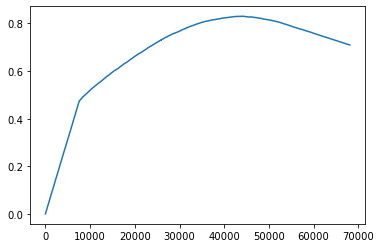

In [17]:
valid_embs, _ = embs_from_model(model, dls.valid)

dists, inds = get_nearest(valid_embs, do_chunk(valid_embs))

valid_df=train_df[train_df.is_valid==True].copy().reset_index()
valid_df = add_target_groups(valid_df)

pairs = sorted_pairs(dists, inds)[:len(valid_df)*10]

_=build_from_pairs(pairs, valid_df.target.to_list())

## Run test set inference

In [ ]:
# fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title', 'label_group']].copy()
# fake_test_df = pd.concat([fake_test_df, fake_test_df])
# fake_test_df = add_target_groups(fake_test_df)
# test_df = fake_test_df

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
test_embs, _ = embs_from_model(model, test_dl)

In [ ]:
dists, inds = get_nearest(test_embs, do_chunk(test_embs))



pairs = sorted_pairs(dists, inds)[:int(len(test_df)*TAKE_PAIRS)]
if 'target' in test_df.columns.to_list():
    _=build_from_pairs(pairs, test_df.target.to_list())

In [ ]:
groups = [[] for _ in range(len(test_df))]
for x,y,v in pairs:
    groups[x].append(y)

In [ ]:
matches = [' '.join(test_df.iloc[g].posting_id.to_list()) for g in groups]
test_df['matches'] = matches

test_df[['posting_id','matches']].to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('./submission.csv')